# Predictive models for phage susceptibility - all phages

Input features: GWAS-identified genes and COGs above the suggestive threshold from all phages combined

Target variables: Susceptibility of Pseudomonas aeruginosa isolates to a phage (0: not infected, 1: infected)

## Import packages

In [3]:
import pandas as pd
import glob
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

## Read and format input data

In [5]:
presence_absence_raw_df = pd.read_csv("../Data/gene_presence_absence.Rtab", sep="\t")

In [6]:
presence_absence_raw_df

,Gene,PaLo600,PaLo601,PaLo602,PaLo603,PaLo604,PaLo605,PaLo606,PaLo607,PaLo608,...,PSA-TIM-IMI-101125,PSA-TIM-IMI-101126,PSA-TIM-IMI-101127,PSA-TIM-IMI-101128,PSA-TIM-IMI-101129,PSA-TIM-IMI-101130,PSA-TIM-IMI-101131,PSA-TIM-IMI-101132,PSA-TIM-IMI-101133,PSA-TIM-IMI-101134
0,aam_1~~~gatA_2~~~amiD_3~~~aam_3~~~QRSL1_2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,group_8989,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,nicA,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,group_8986,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,group_8983,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20670,group_155,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20671,group_89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20672,group_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20673,fitB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# make a list of suggestive COGs

text_file = open("../Data/suggestive_COGs_4phages_unique.txt", "r")
data = text_file.read()
suggestive_COGs_list = data.split("\n")
print(suggestive_COGs_list)
text_file.close()

['ackA_1~~~ackA_2', 'asnB_2~~~asnB_1~~~asnB_3', 'asnB_2~~~asnB_3~~~asnO_3~~~asnB_1', 'btuD_1~~~malK', 'clsA', 'deoA', 'dnaB_1~~~dnaB_2~~~dnaB_3', 'gnu~~~rmd_1~~~rfbB_2', 'gnu~~~rmd_2~~~oleD_1', 'group_10141', 'group_1132', 'group_1155', 'group_1188', 'group_1191', 'group_1194', 'group_14145', 'group_14699', 'group_14756', 'group_1489', 'group_14989', 'group_14990', 'group_1527', 'group_1546', 'group_1570', 'group_1910', 'group_1934', 'group_1970', 'group_2190', 'group_2269', 'group_2374', 'group_2471', 'group_2523', 'group_2554', 'group_2576', 'group_2987', 'group_3007', 'group_3314', 'group_3334', 'group_3716', 'group_3856', 'group_3879', 'group_3946', 'group_3988', 'group_4056', 'group_41', 'group_4149', 'group_417', 'group_4252', 'group_4458', 'group_4613', 'group_5010', 'group_5209', 'group_5273', 'group_5333', 'group_5595', 'group_5618', 'group_5628', 'group_5660', 'group_5815', 'group_5816', 'group_6006', 'group_6125', 'group_6211', 'group_6324', 'group_6392', 'group_6556', 'grou

In [8]:
len(suggestive_COGs_list)

108

In [9]:
# make a list of strains that were used for analysis

text_file = open("../Data/list_of_strains_used.txt", "r")
data = text_file.read()
strains_list = data.split("\n")
print(strains_list)
text_file.close()

['PaLo600', 'PaLo601', 'PaLo602', 'PaLo603', 'PaLo604', 'PaLo605', 'PaLo606', 'PaLo607', 'PaLo608', 'PaLo609', 'PaLo610', 'PaLo611', 'PaLo612', 'PaLo613', 'PaLo614', 'PaLo615', 'PaLo616', 'PaLo617', 'PaLo618', 'PaLo619', 'PaLo620', 'PaLo621', 'PaLo622', 'PaLo623', 'PaLo624', 'PaLo625', 'PaLo626', 'PaLo627', 'PaLo628', 'PaLo629', 'PaLo630', 'PaLo631', 'PaLo632', 'PaLo633', 'PaLo634', 'PaLo635', 'PaLo636', 'PaLo637', 'PaLo638', 'PaLo639', 'PaLo640', 'PaLo641', 'PaLo642', 'PaLo643', 'PaLo644', 'PaLo645', 'PaLo646', 'PaLo647', 'PaLo648', 'PaLo649', 'PaLo650', 'PaLo651', 'PaLo652', 'PaLo653', 'PaLo654', 'PaLo655', 'PaLo656', 'PaLo657', 'PSA-BAB-IMI-102606', 'PSA-BAB-IMI-102604', 'PSA-BAB-IMI-102603', 'PSA-BAB-IMI-102605', 'PSA-BAB-IMI-102280', 'PSA-BAB-IMI-102290', 'PSA-BAB-IMI-102191', 'PSA-BAB-IMI-102190', 'PSA-BAB-IMI-102447', 'PSA-BAB-IMI-102276', 'PSA-BAB-IMI-102451', 'PSA-BAB-IMI-102450', 'PSA-BAB-IMI-102288', 'PSA-BAB-IMI-102194', 'PSA-BAB-IMI-102192', 'PSA-BAB-IMI-102282', 'PSA-BAB-

In [10]:
# filter the gene presence/absence matrix to include only significant COGs and strains used
COGs_df = presence_absence_raw_df[presence_absence_raw_df['Gene'].isin(suggestive_COGs_list)]
COGs_df = pd.concat([COGs_df["Gene"], COGs_df[strains_list]], axis=1)
COGs_df = COGs_df.T
COGs_df.columns = COGs_df.iloc[0]
COGs_df = COGs_df[1:]
COGs_df

Gene,clsA,group_41,mpl~~~ubiX,btuD_1~~~malK,group_5628,treA~~~treA_2,group_1194,group_5010,group_7284,pilA,...,group_4613,group_4458,group_3879,group_14756,group_14699,group_14145,group_8917,group_14990,group_14989,group_10141
PaLo600,1,1,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
PaLo601,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PaLo602,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PaLo603,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PaLo604,1,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSA-BAB-IMI-103434,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PSA-BAB-IMI-103433,1,1,1,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
PSA-BAB-IMI-103443,1,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
PSA-BAB-IMI-103431,1,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Read all phenotype files --> target variable (phage susceptibility)
pheno_dataframes = []

for pheno_file in glob.glob("../Data/all_phenotypes/*.pheno"):
    df = pd.read_csv(pheno_file, sep="\t")
    df = df.set_index('Isolate')
    df = df.loc[strains_list]
    pheno_dataframes.append(df)

In [12]:
combined_df = pd.concat([COGs_df]+pheno_dataframes, axis=1)
combined_df

,clsA,group_41,mpl~~~ubiX,btuD_1~~~malK,group_5628,treA~~~treA_2,group_1194,group_5010,group_7284,pilA,...,group_14989,group_10141,LMA2,LBL3,LUZ7,14_1,PB1,LKD16,LUZ19,LUZ24
PaLo600,1,1,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,1,0,1,1
PaLo601,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PaLo602,1,1,1,1,1,1,1,0,0,0,...,0,0,1,1,0,0,0,0,0,0
PaLo603,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PaLo604,1,1,1,1,1,0,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSA-BAB-IMI-103434,1,1,1,1,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
PSA-BAB-IMI-103433,1,1,1,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
PSA-BAB-IMI-103443,1,1,1,1,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
PSA-BAB-IMI-103431,1,1,1,1,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [13]:
# make list of phages
phages_list = ["LUZ24", "LUZ19", "LKD16", "LUZ7", "LBL3", "14_1", "PB1", "LMA2"]

In [14]:
# make array of samples
X = combined_df.drop(columns=phages_list).to_numpy()
X

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=object)

In [15]:
X.shape

(476, 107)

In [16]:
pheno_df = combined_df[phages_list]
pheno_df

,LUZ24,LUZ19,LKD16,LUZ7,LBL3,14_1,PB1,LMA2
PaLo600,1,1,0,0,0,0,1,0
PaLo601,0,0,0,0,0,0,0,0
PaLo602,0,0,0,0,1,0,0,1
PaLo603,0,0,0,0,0,0,0,0
PaLo604,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
PSA-BAB-IMI-103434,0,0,0,1,0,0,0,0
PSA-BAB-IMI-103433,0,0,0,0,0,0,0,0
PSA-BAB-IMI-103443,0,0,0,0,1,0,0,0
PSA-BAB-IMI-103431,0,0,0,0,1,0,0,0


## Data pre-preprocessing

### Create oversampler
Random oversampling was performed due to class imbalance. The dataset contained more instances with target variable 0 than 1.

In [16]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [17]:
# Create random oversampler --> Randomly duplicate examples in the minority class.
ros = RandomOverSampler(random_state=0)

### Test oversampler

In [45]:
# Split dataset into training and test sets
# In this case, the 'y' is still in the form of a pandas df
X_train, X_test, y_train, y_test = train_test_split(X, pheno_df['LUZ24'], test_size=0.2, random_state=0)

In [46]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((380, 107), (380,), (96, 107), (96,))

In [47]:
y_train.value_counts()

LUZ24
0    305
1     75
Name: count, dtype: int64

In [48]:
y_test.value_counts()

LUZ24
0    78
1    18
Name: count, dtype: int64

In [63]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [64]:
X_resampled

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=object)

In [65]:
y_resampled.value_counts()

LUZ24
0    305
1    305
Name: count, dtype: int64

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
def RandomForestOver(phage):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, pheno_df[phage], test_size=0.2, random_state=0)

    # Oversampling the training data
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    # Define the parameters that are gonna be cross-validated (estimated)
    parameters = {'n_estimators':[10, 20, 50, 100, 150, 200]}

    # Find best parameters for RandomForestClassifier
    clf = GridSearchCV(RandomForestClassifier(random_state=0), parameters).fit(X_resampled, y_resampled)

    # Train RandomForestClassifier with the best estimator
    rf_best = clf.best_estimator_.fit(X_resampled, y_resampled)

    # Predict using the model
    y_pred = rf_best.predict(X_test)

    # Generate classification report
    report = classification_report(y_pred=y_pred, y_true=y_test)

    # Probabilities of predicting an infection (1)
    y_score_Infection = rf_best.predict_proba(X_test)[:, 1]

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_Infection, pos_label=1)

    # Area under ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    return {'report': report, 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

In [55]:
random_forest_results_over = {}

for phage in phages_list:
    random_forest_results_over[phage] = RandomForestOver(phage)

In [56]:
# Classification report for all phages
for phage in phages_list:
    print({phage})
    print(random_forest_results_over[phage]['report'])

{'LUZ24'}
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        78
           1       0.50      0.33      0.40        18

    accuracy                           0.81        96
   macro avg       0.68      0.63      0.64        96
weighted avg       0.79      0.81      0.80        96

{'LUZ19'}
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        66
           1       0.53      0.33      0.41        30

    accuracy                           0.70        96
   macro avg       0.63      0.60      0.60        96
weighted avg       0.67      0.70      0.68        96

{'LKD16'}
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        68
           1       0.57      0.43      0.49        28

    accuracy                           0.74        96
   macro avg       0.68      0.65      0.66        96
weighted avg       0.72      0.74      0.73 

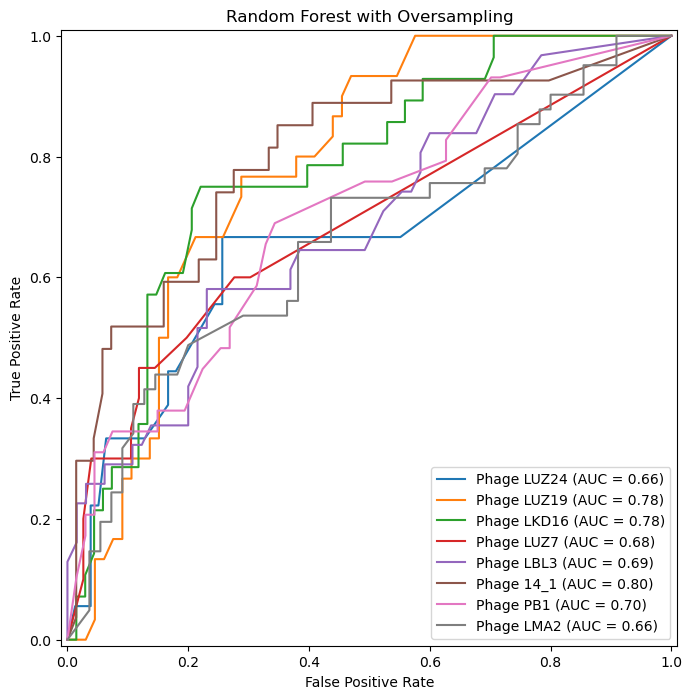

In [57]:
# Plot all ROC curves

plt.figure(figsize=(10, 8))

for phage in phages_list:
    display = RocCurveDisplay(
        fpr=random_forest_results_over[phage]['fpr'], 
        tpr=random_forest_results_over[phage]['tpr'], 
        roc_auc=random_forest_results_over[phage]['roc_auc'], 
        estimator_name=f'Phage {phage}'
    )
    display.plot(ax=plt.gca())  # Use the same Axes for all plots

plt.title("Random Forest with Oversampling")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

In [66]:
def GradientBoostOver(phage):
     # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, pheno_df[phage], test_size=0.2, random_state=0)

    # Oversampling the training data
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    # Define the parameters that are gonna be cross-validated (estimated)
    parameters = {'n_estimators':[10, 20, 50, 100, 150, 200], 'max_depth':[3, None]}

    # Find best parameters for GradientBoostingClassifier
    clf = GridSearchCV(GradientBoostingClassifier(learning_rate=1, random_state=0), parameters).fit(X_resampled, y_resampled)

    # Train GradientBoostingClassifier with the best estimator
    gb_best = clf.best_estimator_.fit(X_resampled, y_resampled)

    # Predict using the model
    y_pred = gb_best.predict(X_test)

    # Generate classification report
    report = classification_report(y_pred=y_pred, y_true=y_test)

    # Probabilities of predicting an infection (1)
    y_score_Infection = gb_best.predict_proba(X_test)[:, 1]

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_Infection, pos_label=1)

    # Area under ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    return {'report': report, 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

In [67]:
gradient_boosting_results_over = {}

for phage in phages_list:
    gradient_boosting_results_over[phage] = GradientBoostOver(phage)

In [68]:
# Classification report for all phages
for phage in phages_list:
    print({phage})
    print(gradient_boosting_results_over[phage]['report'])

{'LUZ24'}
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        78
           1       0.43      0.33      0.38        18

    accuracy                           0.79        96
   macro avg       0.64      0.62      0.62        96
weighted avg       0.77      0.79      0.78        96

{'LUZ19'}
              precision    recall  f1-score   support

           0       0.73      0.82      0.77        66
           1       0.45      0.33      0.38        30

    accuracy                           0.67        96
   macro avg       0.59      0.58      0.58        96
weighted avg       0.64      0.67      0.65        96

{'LKD16'}
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        68
           1       0.55      0.39      0.46        28

    accuracy                           0.73        96
   macro avg       0.66      0.63      0.64        96
weighted avg       0.71      0.73      0.71 

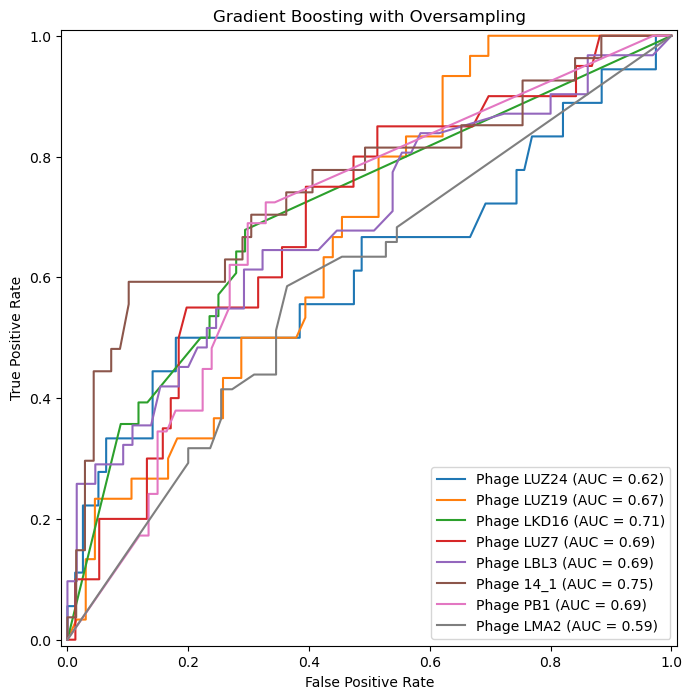

In [69]:
# Plot all ROC curves

plt.figure(figsize=(10, 8))

for phage in phages_list:
    display = RocCurveDisplay(
        fpr=gradient_boosting_results_over[phage]['fpr'], 
        tpr=gradient_boosting_results_over[phage]['tpr'], 
        roc_auc=gradient_boosting_results_over[phage]['roc_auc'], 
        estimator_name=f'Phage {phage}'
    )
    display.plot(ax=plt.gca())  # Use the same Axes for all plots

plt.title("Gradient Boosting with Oversampling")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [70]:
from sklearn.linear_model import LogisticRegressionCV

In [71]:
def LogRegOver(phage):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, pheno_df[phage], test_size=0.2, random_state=0)

    # Oversampling the training data
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    # Make and fit a LogisticRegressionCV
    lr = LogisticRegressionCV(random_state=0).fit(X_resampled, y_resampled)

    # Predict using the model
    y_pred = lr.predict(X_test)

    # Generate classification report
    report = classification_report(y_pred=y_pred, y_true=y_test)

    # Probabilities of predicting an infection (1)
    y_score_Infection = lr.predict_proba(X_test)[:, 1]

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_Infection, pos_label=1)

    # Area under ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    return {'report': report, 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

In [72]:
log_regression_results_over = {}

for phage in phages_list:
    log_regression_results_over[phage] = LogRegOver(phage)

/Users/dennisdharmawan/miniconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dennisdharmawan/miniconda3/envs/sklearn-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [73]:
# Classification report for all phages
for phage in phages_list:
    print({phage})
    print(log_regression_results_over[phage]['report'])

{'LUZ24'}
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        78
           1       0.29      0.44      0.35        18

    accuracy                           0.69        96
   macro avg       0.57      0.59      0.57        96
weighted avg       0.75      0.69      0.71        96

{'LUZ19'}
              precision    recall  f1-score   support

           0       0.84      0.79      0.81        66
           1       0.59      0.67      0.62        30

    accuracy                           0.75        96
   macro avg       0.71      0.73      0.72        96
weighted avg       0.76      0.75      0.75        96

{'LKD16'}
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        68
           1       0.45      0.54      0.49        28

    accuracy                           0.68        96
   macro avg       0.62      0.64      0.63        96
weighted avg       0.69      0.68      0.68 

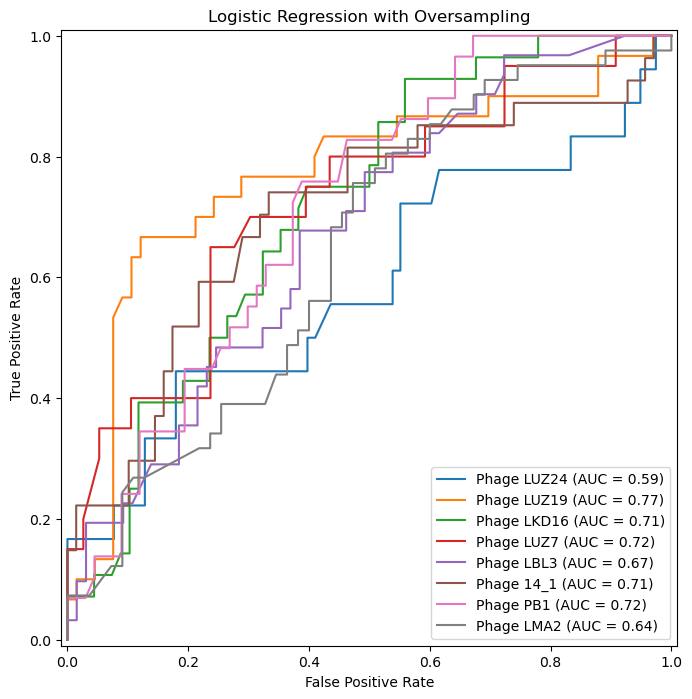

In [74]:
# Plot all ROC curves

plt.figure(figsize=(10, 8))

for phage in phages_list:
    display = RocCurveDisplay(
        fpr=log_regression_results_over[phage]['fpr'], 
        tpr=log_regression_results_over[phage]['tpr'], 
        roc_auc=log_regression_results_over[phage]['roc_auc'], 
        estimator_name=f'Phage {phage}'
    )
    display.plot(ax=plt.gca())  # Use the same Axes for all plots

plt.title("Logistic Regression with Oversampling")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Support Vector Classifier

In [75]:
from sklearn.svm import SVC

In [76]:
def SuppVectorOver(phage):
     # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, pheno_df[phage], test_size=0.2, random_state=0)

    # Oversampling the training data
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    
    clf = GridSearchCV(SVC(probability=True, random_state=0), parameters).fit(X_resampled, y_resampled)

    svc_best = clf.best_estimator_.fit(X_resampled, y_resampled)

    # Predict using the model
    y_pred = svc_best.predict(X_test)

    # Generate classification report
    report = classification_report(y_pred=y_pred, y_true=y_test)

    # Probabilities of predicting an infection (1)
    y_score_Infection = svc_best.predict_proba(X_test)[:, 1]

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_score_Infection, pos_label=1)

    # Area under ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    return {'report': report, 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

In [77]:
svc_results_over = {}

for phage in phages_list:
    svc_results_over[phage] = SuppVectorOver(phage)

In [78]:
# Classification report for all phages
for phage in phages_list:
    print({phage})
    print(svc_results_over[phage]['report'])

{'LUZ24'}
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        78
           1       0.38      0.33      0.35        18

    accuracy                           0.77        96
   macro avg       0.61      0.60      0.61        96
weighted avg       0.76      0.77      0.77        96

{'LUZ19'}
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        66
           1       0.65      0.50      0.57        30

    accuracy                           0.76        96
   macro avg       0.72      0.69      0.70        96
weighted avg       0.75      0.76      0.75        96

{'LKD16'}
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        68
           1       0.60      0.54      0.57        28

    accuracy                           0.76        96
   macro avg       0.71      0.69      0.70        96
weighted avg       0.75      0.76      0.76 

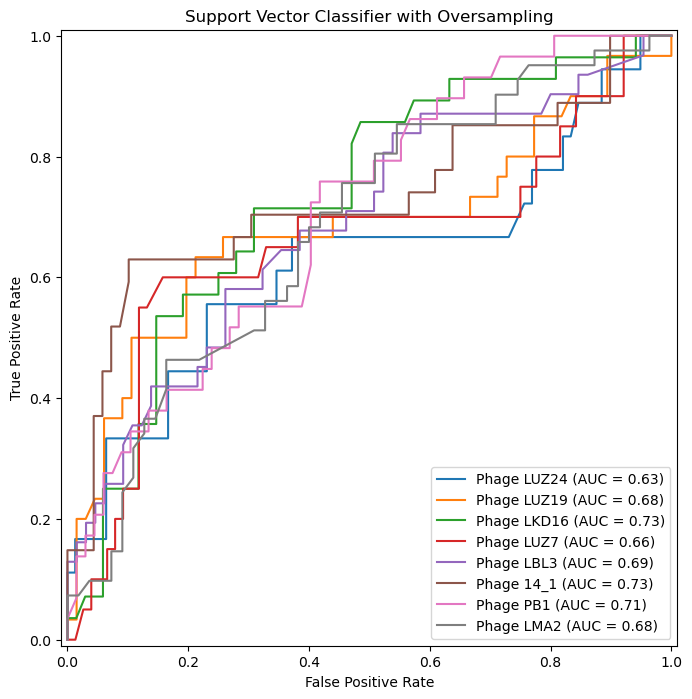

In [79]:
# Plot all ROC curves

plt.figure(figsize=(10, 8))

for phage in phages_list:
    display = RocCurveDisplay(
        fpr=svc_results_over[phage]['fpr'], 
        tpr=svc_results_over[phage]['tpr'], 
        roc_auc=svc_results_over[phage]['roc_auc'], 
        estimator_name=f'Phage {phage}'
    )
    display.plot(ax=plt.gca())  # Use the same Axes for all plots

plt.title("Support Vector Classifier with Oversampling")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()